In [1]:
!pip install tardis-client
!pip install requests
!pip install scipy
!pip install tqdm

import pandas as pd
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import shutil
import os
import gzip
from datetime import date, timedelta
import time
import asyncio
from tardis_client import TardisClient, Channel
import requests
from scipy.interpolate import interp1d
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

# Download data

The following functions download raw high-frequency market data from Tardis dataset: 
- Orderbook L5 updates.
- Executed market orders.
- Open Interest, Mark/Index price of perpetual.

<br>A license API_KEY is required. Check the following link for more information: https://tardis.dev/#pricing

In [2]:
API_KEY = "PLACE_YOUR_API_KEY_HERE"

def getBookByDay(cex, symbol, date, path):
    """
    Download one day order book L5 updates.
    
    :param cex: Exchange name.
    :param symbol: Pair symbol.
    :param date: List containing [year, month, day].
    :param path: Local path to save dataset.
    :return: Saves csv file in specified path.
    """
    year = date[0]
    month = date[1] if date[1] > 9 else '0'+str(date[1])
    day = date[2] if date[2] > 9 else '0' + str(date[2])
    url = f"https://datasets.tardis.dev/v1/{cex}/book_snapshot_5/{year}/{month}/{day}/{symbol}.csv.gz"
    r = requests.get(
        url=url,
        stream=True,
        headers={
            'Authorization': API_KEY
        }
    )
    print(date, r)
    if r.status_code == 200:
        with open(path + f'/{cex}_{symbol}_{year}-{month}-{day}.csv.gz', 'wb') as f:
            r.raw.decode_content = True
            shutil.copyfileobj(r.raw, f)
        with gzip.open(path + f'/{cex}_{symbol}_{year}-{month}-{day}.csv.gz', 'rb') as f:
            file_content = f.read()
            _name = f'{cex}_{symbol}_{year}-{month}-{day}'
            with open(path + f'/{_name}.csv', 'wb') as w:
                w.write(file_content)
        os.remove(path + f'/{cex}_{symbol}_{year}-{month}-{day}.csv.gz')
        
        
def getTradesByDay(cex, symbol, date, path):
    """
    Download one day executed market orders.
    
    :param cex: Exchange name.
    :param symbol: Pair symbol.
    :param date: List containing [year, month, day].
    :param path: Local path to save dataset.
    :return: Saves csv file in specified path.
    """
    year = date[0]
    month = date[1] if date[1] > 9 else '0'+str(date[1])
    day = date[2] if date[2] > 9 else '0' + str(date[2])
    url = f"https://datasets.tardis.dev/v1/{cex}/trades/{year}/{month}/{day}/{symbol}.csv.gz"
    r = requests.get(
        url=url,
        stream=True,
        headers={
            'Authorization': API_KEY
        }
    )
    print(date, r)
    if r.status_code == 200:
        with open(path + f'/{cex}_{symbol}_{year}-{month}-{day}.csv.gz', 'wb') as f:
            r.raw.decode_content = True
            shutil.copyfileobj(r.raw, f)
        with gzip.open(path + f'/{cex}_{symbol}_{year}-{month}-{day}.csv.gz', 'rb') as input_file:
            with open(path + f'/{cex}_{symbol}_{year}-{month}-{day}.csv', 'wb') as output_file:
                shutil.copyfileobj(input_file, output_file)
        os.remove(path + f'/{cex}_{symbol}_{year}-{month}-{day}.csv.gz')
        

def getOpenInterestByDay(cex, symbol, date, path):
    """
    Download Open Interest, Mark Price, and Index Price of perpetual.
    
    :param cex: Exchange name.
    :param symbol: Pair symbol.
    :param date: List containing [year, month, day].
    :param path: Local path to save dataset.
    :return: Saves csv file in specified path.
    """
    year = date[0]
    month = date[1] if date[1] > 9 else '0'+str(date[1])
    day = date[2] if date[2] > 9 else '0' + str(date[2])
    url = f"https://datasets.tardis.dev/v1/{cex}/derivative_ticker/{year}/{month}/{day}/{symbol}.csv.gz"
    r = requests.get(
        url=url,
        stream=True,
        headers={
            'Authorization': API_KEY
        }
    )
    print(date, r)
    if r.status_code == 200:
        with open(path + f'/{cex}_{symbol}_{year}-{month}-{day}.csv.gz', 'wb') as f:
            r.raw.decode_content = True
            shutil.copyfileobj(r.raw, f)
        with gzip.open(path + f'/{cex}_{symbol}_{year}-{month}-{day}.csv.gz', 'rb') as input_file:
            with open(path + f'/{cex}_{symbol}_{year}-{month}-{day}.csv', 'wb') as output_file:
                shutil.copyfileobj(input_file, output_file)
        os.remove(path + f'/{cex}_{symbol}_{year}-{month}-{day}.csv.gz')
    
    data = pd.read_csv(path + f'/{cex}_{symbol}_{year}-{month}-{day}.csv')
    data = data[['timestamp', 'open_interest', 'mark_price', 'index_price']]
    data.dropna(inplace=True)
    data.to_csv(path + f'/{cex}_{symbol}_{year}-{month}-{day}.csv')

In [3]:
# Example
symbol = 'BTCUSDT'
cex = 'binance'
date = [2023, 1, 1]
path = '.'

getBookByDay(cex, symbol, date, path)

data = pd.read_csv(f'{path}/{cex}_{symbol}_{date[0]}-{str(date[1]).zfill(2)}-{str(date[2]).zfill(2)}.csv')
data

[2023, 1, 1] <Response [200]>


,exchange,symbol,timestamp,local_timestamp,asks[0].price,asks[0].amount,bids[0].price,bids[0].amount,asks[1].price,asks[1].amount,...,bids[2].price,bids[2].amount,asks[3].price,asks[3].amount,bids[3].price,bids[3].amount,asks[4].price,asks[4].amount,bids[4].price,bids[4].amount
0,binance,BTCUSDT,1672531201854540,1672531201854540,16542.16,0.00978,16541.58,0.05032,16542.17,0.01838,...,16541.56,0.52505,16542.19,0.21234,16541.55,0.06777,16542.38,0.05379,16541.48,0.13138
1,binance,BTCUSDT,1672531201930000,1672531201934380,16542.16,0.02186,16541.56,0.49636,16542.17,0.01838,...,16541.47,0.02354,16542.19,0.21234,16541.45,0.10611,16542.38,0.05379,16541.44,0.01152
2,binance,BTCUSDT,1672531202030000,1672531202034806,16542.17,0.01838,16541.59,0.01124,16542.18,0.16299,...,16541.57,0.08062,16542.38,0.05379,16541.56,0.63876,16542.40,0.11951,16541.48,0.13138
3,binance,BTCUSDT,1672531202130000,1672531202134459,16542.16,0.00171,16541.65,0.01694,16542.17,0.01838,...,16541.58,0.05149,16542.19,0.21234,16541.56,0.63876,16542.38,0.05379,16541.48,0.13138
4,binance,BTCUSDT,1672531202230000,1672531202235999,16542.18,0.16178,16541.65,0.01894,16542.19,0.21234,...,16541.59,0.07895,16542.40,0.11951,16541.58,0.05149,16542.46,0.36463,16541.56,0.63876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832949,binance,BTCUSDT,1672617599522000,1672617599527054,16617.23,0.12596,16616.89,0.01447,16617.25,0.00097,...,16616.74,0.00770,16617.28,0.15487,16616.73,0.03058,16617.30,0.04765,16616.70,0.17151
832950,binance,BTCUSDT,1672617599622000,1672617599626079,16617.23,0.12596,16616.89,0.01447,16617.25,0.00097,...,16616.75,0.08015,16617.28,0.05457,16616.74,0.00770,16617.30,0.04765,16616.73,0.03058
832951,binance,BTCUSDT,1672617599722000,1672617599726804,16617.20,0.05406,16616.76,0.00440,16617.23,0.12596,...,16616.73,0.03058,16617.26,0.14182,16616.71,0.19986,16617.28,0.06296,16616.69,0.02540
832952,binance,BTCUSDT,1672617599822000,1672617599826867,16617.18,0.05805,16616.87,0.01190,16617.19,0.12416,...,16616.75,0.05835,16617.25,0.00097,16616.73,0.03058,16617.26,0.00752,16616.71,0.19986


# <br><br>Process raw data and generate 1-minute statistics

The following function reads csv files with raw high-frequency data downloaded from Tardis database, and generates 1-minute statistics. The size of the dataset is significantly reduced, making it viable to manage and store data from several months. The following statistics are generated:
- **Spot/Perpetual bids/asks depth (average)**: liquidity in the market.
- **Spot/Perpetual depth ratio (average)**: order book imbalance.
- **Open-Interest (average)**: perpetual markets overall activity.
- **Spot/Perpetual mid-price (average)**: asset price.
- **Spot/Perpetual buys/sells slippage (average)**: market orders slippage wrt last bid/ask.
- **Perpetual buys/sells premium wrt spot (average)**: perpetual market orders price premium compared to Spot order book bid/ask.
- **Market orders frequency (average):** perpetual market orders frequency.
- **Spot/Perpetual buy/sell volume (sum)**: total market orders volume.
- **Spot/Perpetual bid/ask N_tick liquidity (average):** order book liquidity distribution at different tick levels.
- **Spot/Perpetual spread (average):** order book spread, in percentage.
- **Spot/Perpetual bid/ask depth (standard deviation):** variability in market overall liquidity.
- **Spot/Perpetual spread (standard deviation):** variability in order book spread.

In [4]:
def generate_signals(spot_ob, spot_trades, perp_ob, perp_trades, open_interest, path):
    """
    Process 1 day datasets from Spot and Perpetual markets (order book L5 updates, market orders, Open Interest),
    and generates 1-minute relevant statistics. Raw data is summarized, significantly reducing the size of the dataset.
    
    :param spot_ob: path to csv file with Spot order book L5 updates.
    :param spot_trades: path to csv file with Spot market orders.
    :param perp_ob: path to csv file with Perpetual order book L5 updates.
    :param perp_trades: path to csv file with Perpetual market orders.
    :param open_interest: path to csv file with Open Interest data.
    :param path: path for new file with 1-minute statistics.
    :return: saves csv with 1-minute statistics.
    """
    # =====================================================================
    # Read csv files
    # =====================================================================
    spot_ob = pd.read_csv(spot_ob)
    perp_ob = pd.read_csv(perp_ob)
    open_interest = pd.read_csv(open_interest)
    spot_trades = pd.read_csv(spot_trades)
    perp_trades = pd.read_csv(perp_trades)

    spot_ob['timestamp'] /= 1e6
    perp_ob['timestamp'] /= 1e6
    open_interest['timestamp'] /= 1e6
    perp_trades['timestamp'] /= 1e6
    spot_trades['timestamp'] /= 1e6

    # =====================================================================
    # Process orderbook
    # =====================================================================
    spot_ob['asks_depth'] = sum(spot_ob[f'asks[{i}].amount'] * spot_ob[f'asks[{i}].price'] for i in range(5))
    spot_ob['bids_depth'] = sum(spot_ob[f'bids[{i}].amount'] * spot_ob[f'bids[{i}].price'] for i in range(5))
    spot_ob['mid_price'] = 0.5 * (spot_ob['bids[0].price'] + spot_ob['asks[0].price'])
    spot_ob['spread'] = 100 * (spot_ob['asks[0].price'] - spot_ob['bids[0].price']) / spot_ob['mid_price']

    perp_ob['asks_depth'] = sum(perp_ob[f'asks[{i}].amount'] * perp_ob[f'asks[{i}].price'] for i in range(5))
    perp_ob['bids_depth'] = sum(perp_ob[f'bids[{i}].amount'] * perp_ob[f'bids[{i}].price'] for i in range(5))
    perp_ob['mid_price'] = 0.5 * (perp_ob['bids[0].price'] + perp_ob['asks[0].price'])
    perp_ob['spread'] = 100 * (perp_ob['asks[0].price'] - perp_ob['bids[0].price']) / perp_ob['mid_price']

    for tick_id in range(5):
        spot_ob[f'bids[{tick_id}].liquidity'] = spot_ob[f'bids[{tick_id}].price'] * spot_ob[f'bids[{tick_id}].amount']
        spot_ob[f'asks[{tick_id}].liquidity'] = spot_ob[f'asks[{tick_id}].price'] * spot_ob[f'asks[{tick_id}].amount']

        perp_ob[f'bids[{tick_id}].liquidity'] = perp_ob[f'bids[{tick_id}].price'] * perp_ob[f'bids[{tick_id}].amount']
        perp_ob[f'asks[{tick_id}].liquidity'] = perp_ob[f'asks[{tick_id}].price'] * perp_ob[f'asks[{tick_id}].amount']

    # =====================================================================
    # Process trades
    # =====================================================================
    perp_buys = perp_trades[perp_trades['side'] == 'buy']
    perp_sells = perp_trades[perp_trades['side'] == 'sell']
    spot_buys = spot_trades[spot_trades['side'] == 'buy']
    spot_sells = spot_trades[spot_trades['side'] == 'sell']

    # ---------------------------------------------------------------------
    # Perp ob ask and bid interpolated with trades' timestamps
    func_1 = interp1d(perp_ob['timestamp'], perp_ob['mid_price'], fill_value='extrapolate')
    func_2 = interp1d(spot_ob['timestamp'], spot_ob['mid_price'], fill_value='extrapolate')

    perp_buys['perp_mid_price'] = func_1(perp_buys['timestamp'])
    perp_buys['spot_mid_price'] = func_2(perp_buys['timestamp'])
    perp_sells['perp_mid_price'] = func_1(perp_sells['timestamp'])
    perp_sells['spot_mid_price'] = func_2(perp_sells['timestamp'])
    perp_buys['volume'] = perp_buys['price'] * perp_buys['amount']
    perp_sells['volume'] = perp_sells['price'] * perp_sells['amount']
    spot_buys['volume'] = spot_buys['price'] * spot_buys['amount']
    spot_sells['volume'] = spot_sells['price'] * spot_sells['amount']

    # ---------------------------------------------------------------------
    # Perp trades slippage (weighted with order size)
    perp_buys['slippage'] = 100 * (perp_buys['price'] - perp_buys['perp_mid_price']) / perp_buys['perp_mid_price']
    perp_sells['slippage'] = 100 * (perp_sells['perp_mid_price'] - perp_sells['price']) / perp_sells['perp_mid_price']

    perp_buys.loc[perp_buys['slippage'] < 0, 'slippage'] = 0
    perp_sells.loc[perp_sells['slippage'] < 0, 'slippage'] = 0

    perp_buys['weighted_slippage'] = perp_buys['slippage'] * perp_buys['price'] * perp_buys['amount']
    perp_sells['weighted_slippage'] = perp_sells['slippage'] * perp_sells['price'] * perp_sells['amount']

    # ---------------------------------------------------------------------
    # Perp trades premium (wrt spot ob, and weighted with order size)
    perp_buys['premium_wrt_spot'] = 100 * (perp_buys['spot_mid_price'] - perp_buys['price']) / perp_buys[
        'spot_mid_price']
    perp_sells['premium_wrt_spot'] = 100 * (perp_sells['price'] - perp_sells['spot_mid_price']) / perp_sells[
        'spot_mid_price']

    perp_buys['weighted_premium_wrt_spot'] = perp_buys['premium_wrt_spot'] * perp_buys['price'] * perp_buys['amount']
    perp_sells['weighted_premium_wrt_spot'] = perp_sells['premium_wrt_spot'] * perp_sells['price'] * perp_sells[
        'amount']

    # =====================================================================
    # Process Open Interest
    # ===================================================================== 
    # open_interest['seconds'] = open_interest['timestamp'] % 60

    # =====================================================================
    # Generate reference timestamp array, 1min data...
    # =====================================================================
    min_ts = np.max([df['timestamp'].min() for df in [spot_ob, perp_ob, open_interest, perp_trades, spot_trades]])
    max_ts = np.min([df['timestamp'].max() for df in [spot_ob, perp_ob, open_interest, perp_trades, spot_trades]])
    n_ts = int((max_ts - min_ts) / 60) + 1
    ts = np.linspace(min_ts, max_ts, n_ts)

    # =====================================================================
    # Generate signals
    # =====================================================================
    df = {
        'ts': [],
        'spot_asks_depth': [],
        'spot_bids_depth': [],
        'perp_asks_depth': [],
        'perp_bids_depth': [],
        'spot_depth_ratio': [],
        'perp_depth_ratio': [],
        'oi': [],
        'perp_mid_price': [],
        'spot_mid_price': [],
        'sells_slippage': [],
        'buys_slippage': [],
        'sells_premium_wrt_spot': [],
        'buys_premium_wrt_spot': [],
        'market_order_freq': [],
        'perp_volume': [],
        'spot_volume': [],
        'perp_buy_volume': [],
        'perp_sell_volume': [],
        'spot_buy_volume': [],
        'spot_sell_volume': []
    }
    for tick_id in range(5):
        df[f'spot_bids[{tick_id}].liquidity'] = []
        df[f'spot_asks[{tick_id}].liquidity'] = []
        df[f'perp_bids[{tick_id}].liquidity'] = []
        df[f'perp_asks[{tick_id}].liquidity'] = []

    df['spot_spread'] = []
    df['perp_spread'] = []
    df['spot_bids_depth_std'] = []
    df['spot_asks_depth_std'] = []
    df['perp_bids_depth_std'] = []
    df['perp_asks_depth_std'] = []
    df['spot_spread_std'] = []
    df['perp_spread_std'] = []

    for t in ts[:-1]:
        filt_spot_ob = spot_ob[(spot_ob['timestamp'] >= t) & (spot_ob['timestamp'] < t + 60)]
        filt_perp_ob = perp_ob[(perp_ob['timestamp'] >= t) & (perp_ob['timestamp'] < t + 60)]
        filt_open_interest = open_interest[(open_interest['timestamp'] >= t) & (open_interest['timestamp'] < t + 60)]
        filt_perp_sells = perp_sells[(perp_sells['timestamp'] >= t) & (perp_sells['timestamp'] < t + 60)]
        filt_perp_buys = perp_buys[(perp_buys['timestamp'] >= t) & (perp_buys['timestamp'] < t + 60)]
        filt_spot_sells = spot_sells[(spot_sells['timestamp'] >= t) & (spot_sells['timestamp'] < t + 60)]
        filt_spot_buys = spot_buys[(spot_buys['timestamp'] >= t) & (spot_buys['timestamp'] < t + 60)]
        filt_perp_trades = perp_trades[(perp_trades['timestamp'] >= t) & (perp_trades['timestamp'] < t + 60)]

        df['ts'].append(t)
        df['spot_asks_depth'].append(filt_spot_ob['asks_depth'].mean())
        df['spot_bids_depth'].append(filt_spot_ob['bids_depth'].mean())
        df['perp_asks_depth'].append(filt_perp_ob['asks_depth'].mean())
        df['perp_bids_depth'].append(filt_perp_ob['bids_depth'].mean())
        df['spot_depth_ratio'].append(filt_spot_ob['bids_depth'].mean() / filt_spot_ob['asks_depth'].mean())
        df['perp_depth_ratio'].append(filt_perp_ob['bids_depth'].mean() / filt_perp_ob['asks_depth'].mean())
        df['oi'].append(filt_open_interest['open_interest'].mean())
        df['perp_mid_price'].append(filt_perp_ob['mid_price'].mean())
        df['spot_mid_price'].append(filt_spot_ob['mid_price'].mean())
        df['sells_slippage'].append(filt_perp_sells['weighted_slippage'].mean())
        df['buys_slippage'].append(filt_perp_buys['weighted_slippage'].mean())
        df['sells_premium_wrt_spot'].append(filt_perp_sells['weighted_premium_wrt_spot'].mean())
        df['buys_premium_wrt_spot'].append(filt_perp_buys['weighted_premium_wrt_spot'].mean())
        df['market_order_freq'].append(filt_perp_trades['timestamp'].diff().mean())
        df['perp_volume'].append(filt_perp_buys['volume'].sum() + filt_perp_sells['volume'].sum())
        df['spot_volume'].append(filt_spot_buys['volume'].sum() + filt_spot_sells['volume'].sum())
        df['perp_buy_volume'].append(filt_perp_buys['volume'].sum())
        df['perp_sell_volume'].append(filt_perp_sells['volume'].sum())
        df['spot_buy_volume'].append(filt_spot_buys['volume'].sum())
        df['spot_sell_volume'].append(filt_spot_sells['volume'].sum())

        for tick_id in range(5):
            df[f'spot_bids[{tick_id}].liquidity'].append(filt_spot_ob[f'bids[{tick_id}].liquidity'].mean())
            df[f'spot_asks[{tick_id}].liquidity'].append(filt_spot_ob[f'bids[{tick_id}].liquidity'].mean())
            df[f'perp_bids[{tick_id}].liquidity'].append(filt_perp_ob[f'bids[{tick_id}].liquidity'].mean())
            df[f'perp_asks[{tick_id}].liquidity'].append(filt_perp_ob[f'asks[{tick_id}].liquidity'].mean())

        df['spot_spread'].append(filt_spot_ob['spread'].mean())
        df['perp_spread'].append(filt_perp_ob['spread'].mean())
        df['spot_bids_depth_std'].append(filt_spot_ob['bids_depth'].std())
        df['spot_asks_depth_std'].append(filt_spot_ob['asks_depth'].std())
        df['perp_bids_depth_std'].append(filt_perp_ob['bids_depth'].std())
        df['perp_asks_depth_std'].append(filt_perp_ob['asks_depth'].std())
        df['spot_spread_std'].append(filt_spot_ob['spread'].std())
        df['perp_spread_std'].append(filt_perp_ob['spread'].std())

    # =====================================================================
    # Save data
    # =====================================================================
    pd.DataFrame(df).to_csv(path)

# <br><br>Generate summary files with 1-min stats for specified dates

Use previous functions and do the following:
- Download raw high-freq daily datasets from Tardis database: order book L5 snapshots, market orders, Open-Interest.
- Process datasets, generate summary csv files with 1-min stats, and remove raw data.

In [5]:
from datetime import date, timedelta

# Specify dates
start_date = [2024, 1, 1]
end_date = [2024, 1, 6]

actual_date = start_date.copy()
dates = [actual_date]
while actual_date <= end_date:
    actual_date = date(actual_date[0], actual_date[1], actual_date[2]) + timedelta(days=1)
    actual_date = [actual_date.year, actual_date.month, actual_date.day]
    dates.append(actual_date)
dates

[[2024, 1, 1],
 [2024, 1, 2],
 [2024, 1, 3],
 [2024, 1, 4],
 [2024, 1, 5],
 [2024, 1, 6],
 [2024, 1, 7]]

In [6]:
# Define list of coins
coins = ['BTC', 'ETH']

In [7]:
def create_dir(path):
    if not os.path.exists(path):
        os.mkdir(path)

####################################################################################################
####################################################################################################
for coin in coins:
    create_dir('tardis_data_github')
    
    if os.path.exists(f'tardis_data_github/{coin}'):
        continue
    
    with tqdm(total=len(dates)) as pbar:
        for d in dates:
            # ---------------------------------------------------------
            # Create directories
            # ---------------------------------------------------------
            create_dir(f'tardis_data_github/{coin.upper()}')
            create_dir(f'tardis_data_github/{coin.upper()}/binance-futures')
            create_dir(f'tardis_data_github/{coin.upper()}/binance-spot')
            create_dir(f'tardis_data_github/{coin.upper()}/binance-futures/orderbook')
            create_dir(f'tardis_data_github/{coin.upper()}/binance-futures/trades')
            create_dir(f'tardis_data_github/{coin.upper()}/binance-futures/open_interest')
            create_dir(f'tardis_data_github/{coin.upper()}/binance-spot/orderbook')
            create_dir(f'tardis_data_github/{coin.upper()}/binance-spot/trades')
            create_dir(f'tardis_data_github/{coin.upper()}/processed')

            # ---------------------------------------------------------
            # Download spot orderbook and trades
            # ---------------------------------------------------------
            cex = 'binance'
            symbol = f'{coin.upper()}USDT'

            getBookByDay(cex, symbol, d, f'tardis_data_github/{coin.upper()}/binance-spot/orderbook')
            getTradesByDay(cex, symbol, d, f'tardis_data_github/{coin.upper()}/binance-spot/trades')

            # ---------------------------------------------------------
            # Download perp orderbook, trades and open-interest
            # ---------------------------------------------------------
            cex = 'binance-futures'
            symbol = f'{coin.upper()}USDT'

            getBookByDay(cex, symbol, d, f'tardis_data_github/{coin.upper()}/binance-futures/orderbook')
            getTradesByDay(cex, symbol, d, f'tardis_data_github/{coin.upper()}/binance-futures/trades')
            getOpenInterestByDay(cex, symbol, d, f'tardis_data_github/{coin.upper()}/binance-futures/open_interest')

            # ---------------------------------------------------------
            # Generate signals
            # ---------------------------------------------------------
            str_date = str(d[0]) + '-' + str(d[1]).zfill(2) + '-' + str(d[2]).zfill(2)
            dataset = f'{coin.upper()}USDT_{str_date}'

            spot_ob = f'tardis_data_github/{coin.upper()}/binance-spot/orderbook/binance_{dataset}.csv'
            perp_ob = f'tardis_data_github/{coin.upper()}/binance-futures/orderbook/binance-futures_{dataset}.csv'
            open_interest = f'tardis_data_github/{coin.upper()}/binance-futures/open_interest/binance-futures_{dataset}.csv'
            spot_trades = f'tardis_data_github/{coin.upper()}/binance-spot/trades/binance_{dataset}.csv'
            perp_trades = f'tardis_data_github/{coin.upper()}/binance-futures/trades/binance-futures_{dataset}.csv'
            path = f'tardis_data_github/{coin.upper()}/processed/{dataset}.csv'

            generate_signals(spot_ob, spot_trades, perp_ob, perp_trades, open_interest, path)

            # ---------------------------------------------------------
            # Remove Tardis data
            # ---------------------------------------------------------
            os.remove(spot_ob)
            os.remove(perp_ob)
            os.remove(open_interest)
            os.remove(spot_trades)
            os.remove(perp_trades)

            pbar.update(1)

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

[2024, 1, 1] <Response [200]>
[2024, 1, 1] <Response [200]>
[2024, 1, 1] <Response [200]>
[2024, 1, 1] <Response [200]>
[2024, 1, 1] <Response [200]>


 14%|████████████                                                                        | 1/7 [00:42<04:15, 42.62s/it]

[2024, 1, 2] <Response [200]>
[2024, 1, 2] <Response [200]>
[2024, 1, 2] <Response [200]>
[2024, 1, 2] <Response [200]>
[2024, 1, 2] <Response [200]>


 29%|████████████████████████                                                            | 2/7 [01:47<04:37, 55.47s/it]

[2024, 1, 3] <Response [200]>
[2024, 1, 3] <Response [200]>
[2024, 1, 3] <Response [200]>
[2024, 1, 3] <Response [200]>
[2024, 1, 3] <Response [200]>


 43%|████████████████████████████████████                                                | 3/7 [02:54<04:04, 61.07s/it]

[2024, 1, 4] <Response [200]>
[2024, 1, 4] <Response [200]>
[2024, 1, 4] <Response [200]>
[2024, 1, 4] <Response [200]>
[2024, 1, 4] <Response [200]>


 57%|████████████████████████████████████████████████                                    | 4/7 [03:49<02:55, 58.64s/it]

[2024, 1, 5] <Response [200]>
[2024, 1, 5] <Response [200]>
[2024, 1, 5] <Response [200]>
[2024, 1, 5] <Response [200]>
[2024, 1, 5] <Response [200]>


 71%|████████████████████████████████████████████████████████████                        | 5/7 [04:51<01:59, 59.61s/it]

[2024, 1, 6] <Response [200]>
[2024, 1, 6] <Response [200]>
[2024, 1, 6] <Response [200]>
[2024, 1, 6] <Response [200]>
[2024, 1, 6] <Response [200]>


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [05:27<00:51, 51.60s/it]

[2024, 1, 7] <Response [200]>
[2024, 1, 7] <Response [200]>
[2024, 1, 7] <Response [200]>
[2024, 1, 7] <Response [200]>
[2024, 1, 7] <Response [200]>


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

[2024, 1, 1] <Response [200]>
[2024, 1, 1] <Response [200]>
[2024, 1, 1] <Response [200]>
[2024, 1, 1] <Response [200]>
[2024, 1, 1] <Response [200]>


 14%|████████████                                                                        | 1/7 [00:34<03:28, 34.83s/it]

[2024, 1, 2] <Response [200]>
[2024, 1, 2] <Response [200]>
[2024, 1, 2] <Response [200]>
[2024, 1, 2] <Response [200]>
[2024, 1, 2] <Response [200]>


 29%|████████████████████████                                                            | 2/7 [01:22<03:31, 42.37s/it]

[2024, 1, 3] <Response [200]>
[2024, 1, 3] <Response [200]>
[2024, 1, 3] <Response [200]>
[2024, 1, 3] <Response [200]>
[2024, 1, 3] <Response [200]>


 43%|████████████████████████████████████                                                | 3/7 [02:19<03:15, 48.87s/it]

[2024, 1, 4] <Response [200]>
[2024, 1, 4] <Response [200]>
[2024, 1, 4] <Response [200]>
[2024, 1, 4] <Response [200]>
[2024, 1, 4] <Response [200]>


 57%|████████████████████████████████████████████████                                    | 4/7 [03:02<02:19, 46.55s/it]

[2024, 1, 5] <Response [200]>
[2024, 1, 5] <Response [200]>
[2024, 1, 5] <Response [200]>
[2024, 1, 5] <Response [200]>
[2024, 1, 5] <Response [200]>


 71%|████████████████████████████████████████████████████████████                        | 5/7 [03:46<01:31, 45.86s/it]

[2024, 1, 6] <Response [200]>
[2024, 1, 6] <Response [200]>
[2024, 1, 6] <Response [200]>
[2024, 1, 6] <Response [200]>
[2024, 1, 6] <Response [200]>


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [04:23<00:42, 42.83s/it]

[2024, 1, 7] <Response [200]>
[2024, 1, 7] <Response [200]>
[2024, 1, 7] <Response [200]>
[2024, 1, 7] <Response [200]>
[2024, 1, 7] <Response [200]>


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:59<00:00, 42.82s/it]


# <br><br>Generate trading signals (model features) from 1-min stats

Read csv files with 1-min stats and generate relevant signals, which can be used as features to train a model. The following process is applied for signal generation:
- Apply moving average to filter noise. We are interested in analyzing mean activity in the market in previous time-window.
- Normalize signals applying Standard Scaler: (x - x.mean()) / x.std()

In [19]:
for coin in tqdm(coins):
    print(coin)
    
    # ----------------------------------------------------------------------------------------
    # Join every dataset
    # ----------------------------------------------------------------------------------------
    files = os.listdir(f'tardis_data_github/{coin}/processed')
    data = pd.read_csv(f'tardis_data_github/{coin}/processed/{files[0]}')
    for f in files[1:]:
        data = pd.concat([data, pd.read_csv(f'tardis_data_github/{coin}/processed/{f}')])

    data.drop([k for k in data.keys() if 'unnamed' in k.lower()], axis=1, inplace=True)
    # perp_spread signal WRONG, remove from dataset...
    data.drop(['perp_spread'], axis=1, inplace=True)

    # ----------------------------------------------------------------------------------------
    # Replace 0 volume data
    # ----------------------------------------------------------------------------------------
    zero_ids = data.index[data['perp_volume'] == 0]
    data['perp_volume'].replace(0, np.nan, inplace=True)
    data['perp_volume'].fillna(method='ffill', inplace=True)
    data['perp_volume'].fillna(method='bfill', inplace=True)

    zero_ids = data.index[data['spot_volume'] == 0]
    data['spot_volume'].replace(0, np.nan, inplace=True)
    data['spot_volume'].fillna(method='ffill', inplace=True)
    data['spot_volume'].fillna(method='bfill', inplace=True)

    # ----------------------------------------------------------------------------------------
    # Generate signals
    # ----------------------------------------------------------------------------------------
    data['spot_bid_strenght'] = data['spot_bids_depth']
    data['spot_ask_strenght'] = data['spot_asks_depth']
    data['perp_bid_strenght'] = data['perp_bids_depth']
    data['perp_ask_strenght'] = data['perp_asks_depth']
    data['spot_imbalance'] = data['spot_bids_depth'] / data['spot_asks_depth']
    data['perp_imbalance'] = data['perp_bids_depth'] / data['perp_asks_depth']
    data['big_player'] = (data['oi'].pct_change() + 1) / (data['perp_mid_price'].pct_change() + 1)
    data['bull_flow'] = data['buys_slippage']
    data['bear_flow'] = data['sells_slippage']
    data['volshark'] = data['spot_volume'] / data['perp_volume']
    data['bull_excess'] = data['buys_premium_wrt_spot']
    data['bear_excess'] = data['sells_premium_wrt_spot']
    data['flow_stagnation'] = data['market_order_freq']

    data = data[[
        'ts',
        'spot_bid_strenght',
        'spot_ask_strenght',
        'perp_bid_strenght',
        'perp_ask_strenght',
        'spot_imbalance',
        'perp_imbalance',
        'big_player',
        'bull_flow',
        'bear_flow',
        'volshark',
        'bull_excess',
        'bear_excess',
        'flow_stagnation',
        'perp_mid_price'
    ]]

    # ----------------------------------------------------------------------------------------
    # Normalize signals, and generate MA
    # ----------------------------------------------------------------------------------------
    columns = [
        'spot_bid_strenght',
        'spot_ask_strenght',
        'perp_bid_strenght',
        'perp_ask_strenght',
        'spot_imbalance',
        'perp_imbalance',
        'big_player',
        'bull_flow',
        'bear_flow',
        'volshark',
        'bull_excess',
        'bear_excess',
        'flow_stagnation',
    ]

    for column in columns:
        # Normalize signals
        _mean = data[column].mean()
        _std = data[column].std()
        data[column] -= _mean
        data[column] /= _std

        # Generate MA
        data[f'{column}_4h'] = data[column].rolling(4*60).mean()

        # Normalize MA
        _mean = data[f'{column}_4h'].mean()
        _std = data[f'{column}_4h'].std()
        data[f'{column}_4h'] -= _mean
        data[f'{column}_4h'] /= _std

    # ----------------------------------------------------------------------------------------
    # Replace NaN values
    # ----------------------------------------------------------------------------------------
    data.fillna(method='ffill', inplace=True)
    data.fillna(method='bfill', inplace=True)
    data.dropna(inplace=True)
    
    # ----------------------------------------------------------------------------------------
    # Save data
    # ----------------------------------------------------------------------------------------
    data.to_csv(f'tardis_data_github/{coin}/signals.csv')

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

BTC


 50%|██████████████████████████████████████████                                          | 1/2 [00:00<00:00,  2.76it/s]

ETH


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.77it/s]


# <br><br>Plot some signals

<IPython.core.display.Javascript object>


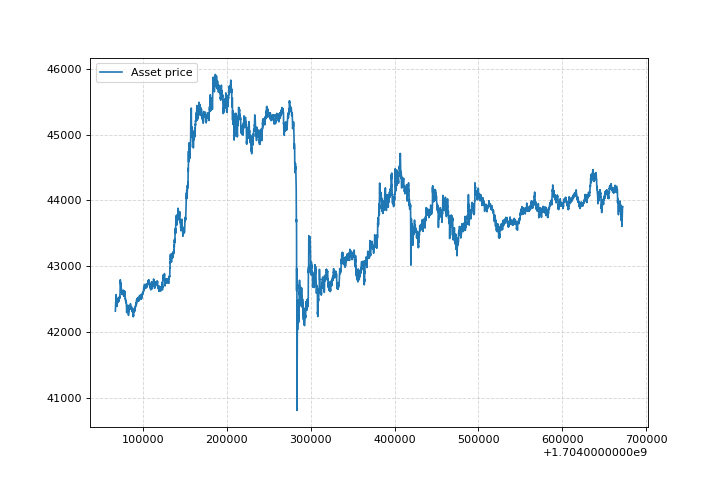

<IPython.core.display.Javascript object>


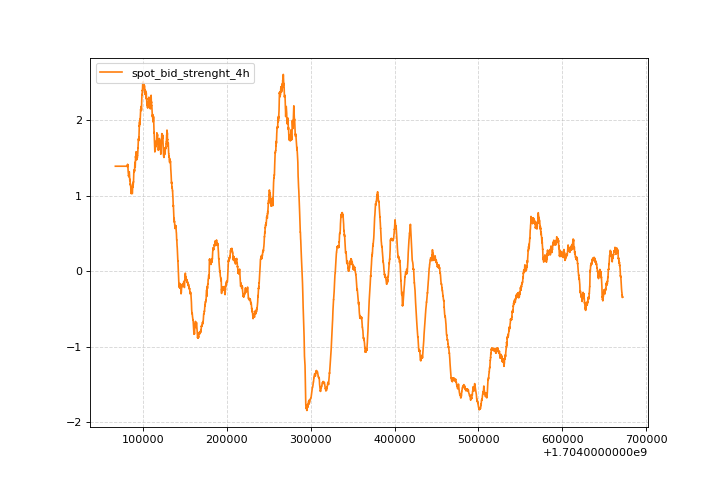

<IPython.core.display.Javascript object>


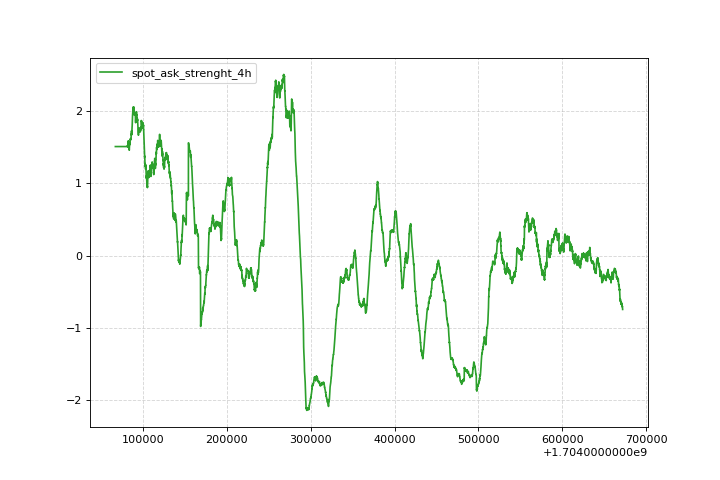

<IPython.core.display.Javascript object>


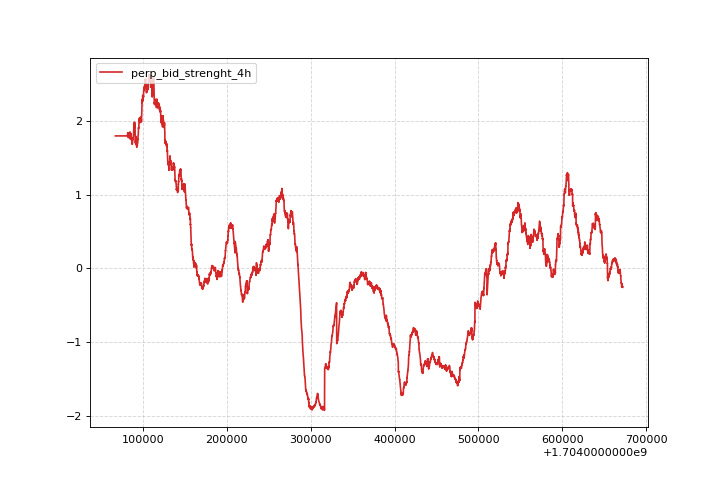

<IPython.core.display.Javascript object>


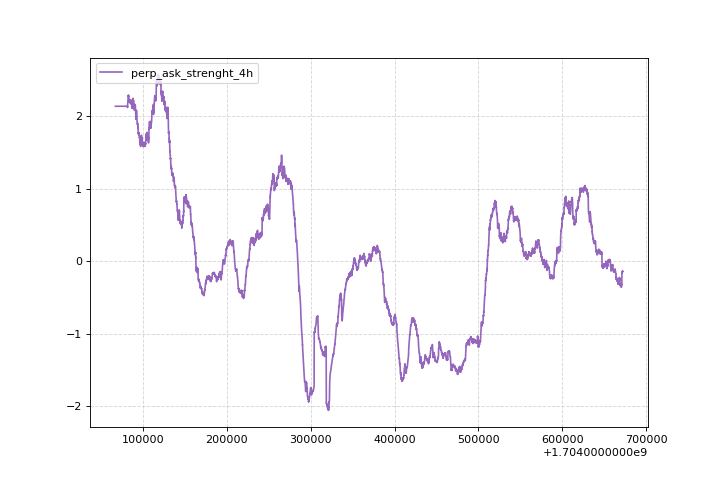

<IPython.core.display.Javascript object>


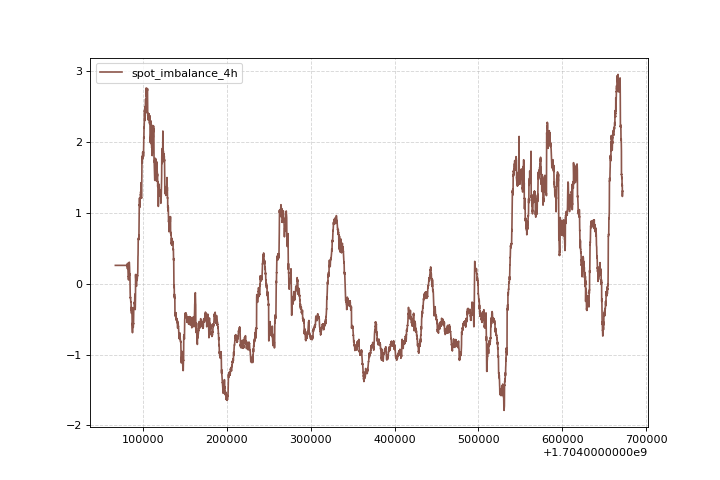

<IPython.core.display.Javascript object>


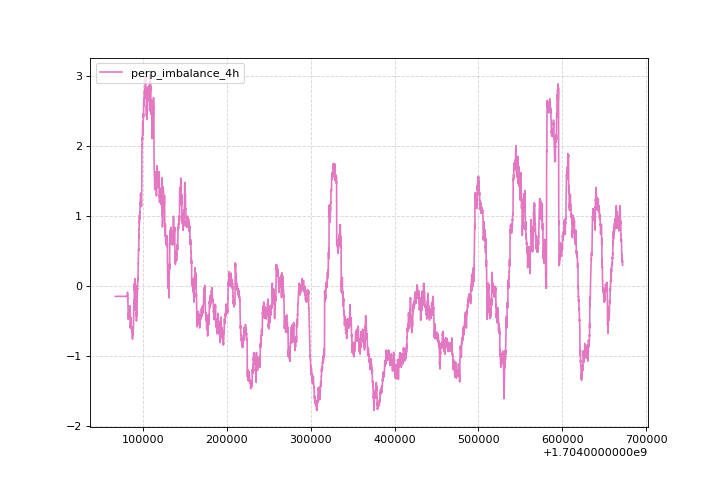

<IPython.core.display.Javascript object>


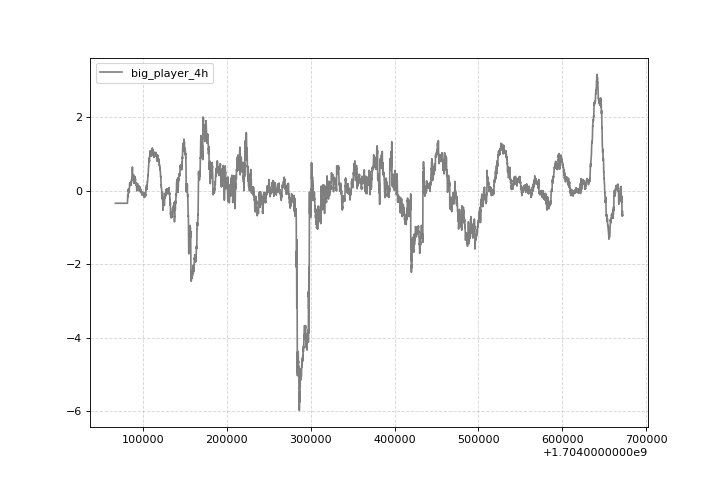

<IPython.core.display.Javascript object>


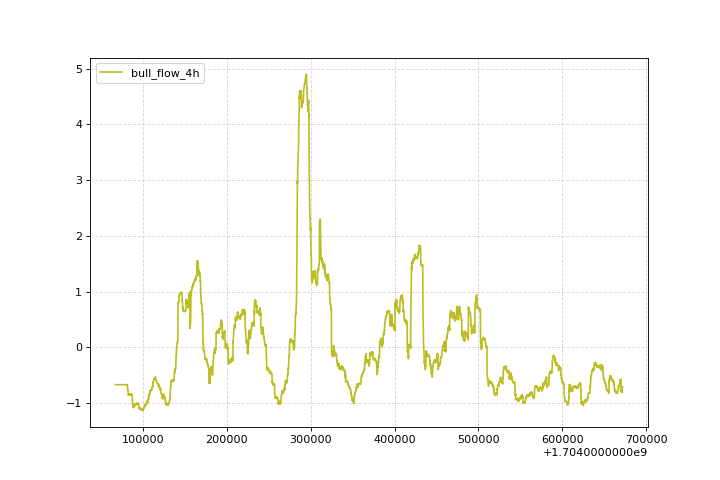

<IPython.core.display.Javascript object>


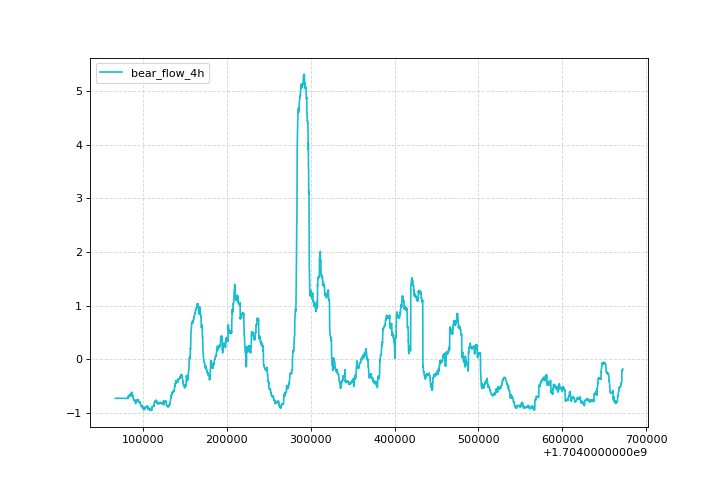

<IPython.core.display.Javascript object>


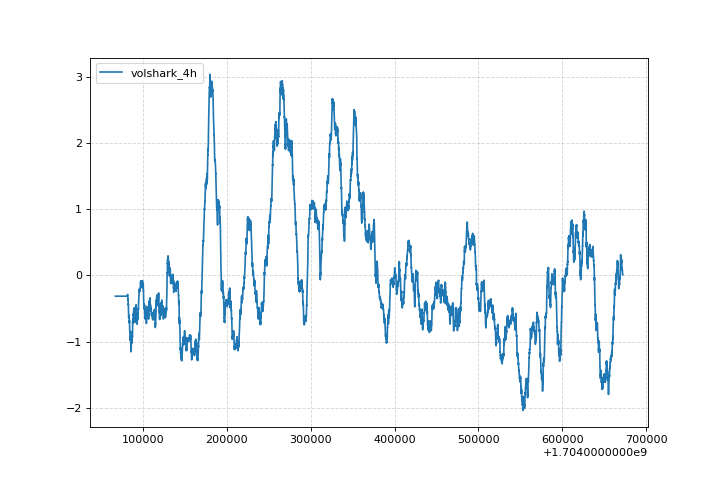

<IPython.core.display.Javascript object>


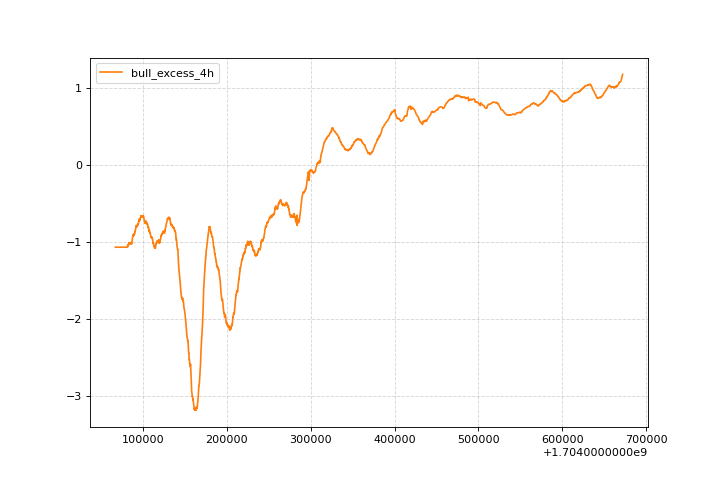

<IPython.core.display.Javascript object>


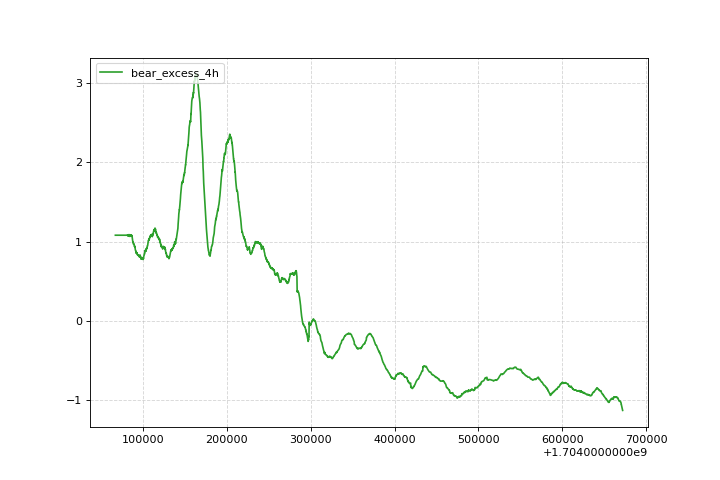

<IPython.core.display.Javascript object>


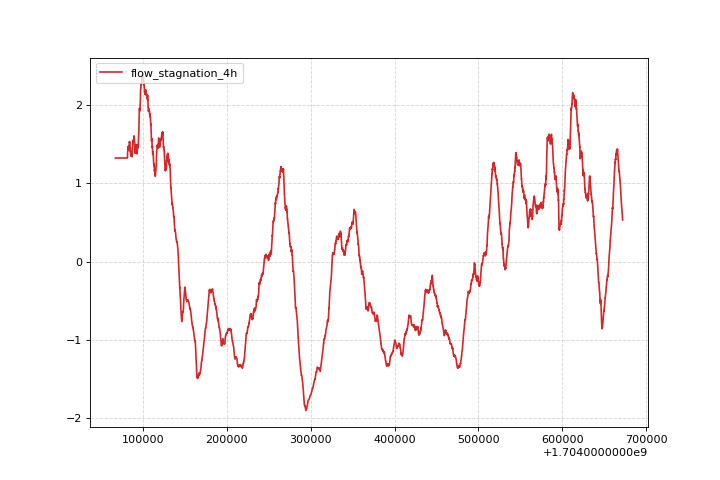

In [23]:
data = pd.read_csv('tardis_data_github/BTC/signals.csv')

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(data['ts'], data['perp_mid_price'], label='Asset price')
ax.legend(loc='upper left')
ax.grid(linestyle='--', alpha=.5)

for color_id, k in enumerate([x for x in data.keys() if '_4h' in x]):
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.plot(data['ts'], data[k], label=k, color=f'C{color_id+1}')
    ax.legend(loc='upper left')
    ax.grid(linestyle='--', alpha=.5)